In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My Drive/FastAI/main

/content/drive/My Drive/FastAI/main


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['uncased-l12-h768-a12', 'jigsaw-toxic-comment-classification-challenge', 'infineon']


In [0]:
from fastai.text import *

In [4]:
train = pd.read_csv("../input/infineon/infineonTrainDataTransformed.csv", encoding="ISO-8859-1")
train.head()

,id,comment_text,Natural Resources,Music and Audio,Platforms,Information Technology,Messaging and Telecommunications,Transportation,Consumer Goods,Real Estate,Video,Navigation and Mapping,Artificial Intelligence,Clothing and Apparel,Administrative Services,Energy,Travel and Tourism,Internet Services,Education,Commerce and Shopping,Sports,Lending and Investments,Sustainability,Biotechnology,Science and Engineering,Data and Analytics,Hardware,Content and Publishing,Gaming,Sales and Marketing,Financial Services,Government and Military,Mobile,Media and Entertainment,Events,Payments,Consumer Electronics,Health Care,Food and Beverage,Software,Professional Services,Design,Agriculture and Farming,Privacy and Security,Advertising,Manufacturing,Community and Lifestyle,Apps
0,35440,enlighted is an iot platform for commercial re...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13117,darrb is a platform that connects people who w...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,44816,grand perfecta is a leading provider of data a...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,4710,iapp4me offers tools that enable its users to ...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,26697,dealfaint provide top quality products and unp...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [0]:
train['comment_text'] = train['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [7]:
train['comment_text'].isna().any()

True

In [0]:
train=train.dropna()

In [9]:
len(train)

40668

In [0]:
test = pd.read_csv("../input/infineon/infineonTestDataTransformed.csv", encoding="ISO-8859-1")

test_id = test['id']
test['comment_text'] = test['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [0]:
test['comment_text'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Name: comment_text, Length: 5000, dtype: bool

In [0]:
print(test[test["comment_text"].isnull()])

         id comment_text
4532  54359          NaN


In [13]:
len(test)

4999

In [0]:
test=test.dropna()

In [14]:
data = (TextList.from_df(train, cols='comment_text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,"- in - class sensor and analytics platform , we provide smart energy solutions for commercial buildings . our technology reduces costs and improves the comfort of workspaces and the efficiency of the people who work in them . \r\r \n \r\r \n our solutions go beyond theory . customers are saving millions in energy costs - up to 70 % in some instances - while making smarter business"
1,"need a technology partner , contact us now and wea?tll help you make it a reality . xxbos the transhumanist party is a u.s . political organization that promotes science , health , and technology among its xxunk to the official site of the transhumanist party , an american political organization dedicated to putting science , \r\r \n health , and technology at the forefront of united states politics"
2,"tags , introduction , fans , tweets and verification information , filling out your personal business card . when users find someone of interest they can swap business cards and then chat online . \r\r \n \r\r \n to help users quickly find people of interest zaizher offers a filter / search function and events section . through the filter function users can filter by distance and industry ,"
3,"unity ( one ) in the xxunk ( pluribus ) , the capability of recognizing one face in a huge collection of pixels or recognizing the concept of tree despite the huge variety of sizes , shapes , and colours of the different xxunk . read more information in the pluribus one s official website : xxunk xxbos mobikart is an ecosystem for everything xxunk is an ecosystem for everything"
4,": all of its advanced optical scanning devices are packaged with an enabling software driver necessary for operation . this software provides the main capabilities necessary to use biometric capture devices , including user feedback and image support , device control and autocapture . its proprietary autocapture technology facilitates the rapid capture of images suitable for matching . the company also offers software drivers equipped with programming tools for use"


In [15]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


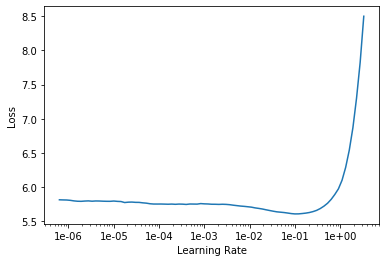

In [17]:
learn.recorder.plot()


In [18]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.150721,4.752842,0.236269,21:35


In [0]:
learn.save_encoder('fine_tuned_enc2')

In [0]:
label_cols = ['Natural Resources',
       'Music and Audio', 'Platforms', 'Information Technology',
       'Messaging and Telecommunications', 'Transportation', 'Consumer Goods',
       'Real Estate', 'Video', 'Navigation and Mapping',
       'Artificial Intelligence', 'Clothing and Apparel',
       'Administrative Services', 'Energy', 'Travel and Tourism',
       'Internet Services', 'Education', 'Commerce and Shopping', 'Sports',
       'Lending and Investments', 'Sustainability', 'Biotechnology',
       'Science and Engineering', 'Data and Analytics', 'Hardware',
       'Content and Publishing', 'Gaming', 'Sales and Marketing',
       'Financial Services', 'Government and Military', 'Mobile',
       'Media and Entertainment', 'Events', 'Payments', 'Consumer Electronics',
       'Health Care', 'Food and Beverage', 'Software', 'Professional Services',
       'Design', 'Agriculture and Farming', 'Privacy and Security',
       'Advertising', 'Manufacturing', 'Community and Lifestyle', 'Apps']

In [21]:
test_datalist = TextList.from_df(test, cols='comment_text', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='comment_text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
"xxbos search maximizer offers sem services , including search engine optimization , ppc advertising , and web analytics xxunk maximizer co . ,ltd a a1a,?a a , a?a a , a2a a1a,?a a , a?oa a1a?!a a , a""ca a , a!a a , a?a a , a?a a , aca a , a?a a , a?""a a , a?""a a , a?a a1e?a a , a?a a , a?a",Internet Services;Sales and Marketing;Media and Entertainment;Advertising
"xxbos iheartmedia is a mass media company that provides a range of multiplatform advertising and marketing xxunk , inc . , previously clear channel communications , was founded in san antonio , tx with the purchase of a single radio station in 1972 . after decades of growing media assets globally , the company has become one of the worlda?ts leading media and entertainment companies , operating as cc media",Video;Sales and Marketing;Media and Entertainment;Advertising
"xxbos gatehouse media s business model is to be the preeminent provider of local content and advertising in the small and midsize xxunk media s business model is to be the preeminent provider of local content and advertising in the small and midsize markets we serve . their portfolio of products , which includes 404 community publications and more than 350 related websites and six yellow page directories , serves",Content and Publishing;Sales and Marketing;Media and Entertainment;Advertising
"xxbos irobot is an american technology company that designs and builds behavior - based ai xxunk designs and builds robots that empower people to do more . the company s home robots help people find smarter ways to clean and accomplish more in their daily lives . irobot s portfolio of solutions features proprietary technologies for the connected home and advanced concepts in navigation , mobility , manipulation and artificial",Internet Services;Science and Engineering;Hardware;Consumer Electronics;Software
"xxbos evogene is a world leading developer of improved plant traits , such as yield and drought tolerance , for a wide diversity of key xxunk is a world leading developer of improved plant traits , such as yield and drought tolerance , for a wide diversity of key crops through the use of plant genomics . the company focuses on utilizing its proprietary computational genomic technologies to provide a",Biotechnology;Science and Engineering;Health Care;Agriculture and Farming


In [0]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc2')
learn_classifier.freeze() 


In [23]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


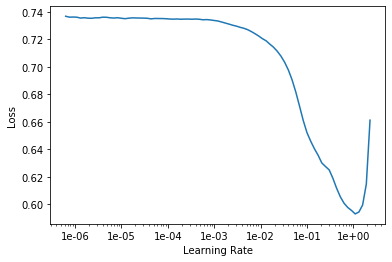

In [24]:
learn_classifier.recorder.plot()


In [25]:
learn_classifier.fit_one_cycle(1, 2e-1, moms=(0.8,0.7))


epoch,train_loss,valid_loss,time
0,0.236438,0.217584,08:35


In [26]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(2e-2/(2.6**4),2e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.211682,0.196220,10:07


In [27]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(8e-3/(2.6**4),8e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.194233,0.182939,14:31


In [28]:
learn_classifier.show_results()

text,target,prediction
"xxbos usg is north america s leading producer of gypsum wallboard , joint compound and a vast array of related products for the xxunk corporation is a manufacturer and distributor of innovative , high - performance building systems through its united states gypsum company , usg interiors , llc , and l&w supply corporation subsidiaries and its usg boral building products joint venture . headquartered in chicago , usg worldwide",Real Estate;Science and Engineering;Design;Manufacturing,Manufacturing
"xxbos specializes in the design , merchandising , sales , and marketing of a variety of lifestyle branded activewear , apparel , and xxunk apparel , inc . specializes in the design , merchandising , sales , and marketing of a variety of lifestyle branded activewear , apparel , and headwear for men , women , juniors , youth and children at a wide range of price points . delta",Clothing and Apparel;Sales and Marketing;Design;Community and Lifestyle,Clothing and Apparel;Commerce and Shopping;Design
"xxbos solarwinds develops a technology that manages it xxunk our founding in 1999 , xxunk mission has been to provide purpose - built products that are designed to make jobs easier for it professionals , msps , and devops pros . we offer value - driven products and tools that solve a broad range of it management xxunk those challenges are related to networks , servers , applications , storage",Information Technology;Internet Services;Hardware;Software;Privacy and Security,Information Technology;Internet Services;Hardware;Software;Privacy and Security
"xxbos xxunk delhaize xxunk et cie le lion sa is a belgium - based food xxunk delhaize xxunk et cie le lion sa is a belgium - based food retailer . the company is principally engaged in the operation of supermarkets in belgium , the united states ( southeast and mid - atlantic as well as northeast and sweetbay in florida ) , greece , serbia , bosnia and herzegovina",Commerce and Shopping;Hardware;Food and Beverage;Software,Commerce and Shopping;Food and Beverage
"xxbos mips technologies , inc . develops embedded processors and related intellectual property for use in performance - oriented markets , such xxunk technologies , inc . develops embedded processors and related intellectual property for use in performance - oriented markets , such as digital entertainment , wired and wireless communications ( including broadband access ) , office automation , security , and automotive markets . its designs are based",Science and Engineering;Hardware;Mobile;Professional Services,Hardware;Consumer Electronics;Software;Manufacturing


In [29]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()


In [30]:
labels

array([[2.335797e-04, 8.650985e-03, 1.807728e-01, 6.944574e-02, ..., 9.154445e-01, 7.790661e-05, 2.149906e-03,
        3.334934e-01],
       [3.758703e-04, 6.391373e-02, 6.949289e-01, 6.079246e-02, ..., 5.322966e-02, 4.743912e-04, 3.148242e-02,
        7.784519e-01],
       [1.037545e-02, 1.601977e-03, 5.729454e-02, 7.029065e-01, ..., 1.227459e-02, 1.386026e-02, 5.977490e-03,
        1.221721e-01],
       [2.999216e-01, 1.831136e-03, 2.060088e-03, 1.495671e-01, ..., 6.330823e-04, 8.618490e-01, 3.284021e-03,
        3.153495e-03],
       ...,
       [1.056477e-03, 1.860310e-02, 1.131962e-02, 1.551622e-01, ..., 7.305346e-03, 3.802849e-04, 4.359940e-01,
        9.787886e-02],
       [7.816227e-04, 7.642115e-05, 1.731509e-03, 7.346262e-01, ..., 4.393587e-04, 1.416523e-03, 5.160416e-03,
        1.802999e-02],
       [1.670524e-02, 3.931766e-03, 2.026980e-02, 6.364020e-01, ..., 7.150916e-03, 3.589348e-01, 8.514930e-03,
        4.226977e-02],
       [1.871835e-02, 1.000614e-03, 1.166991e-03, 

In [31]:
submission = pd.DataFrame({'id': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1)

submission.to_csv('submission2.csv', index=False)
submission.head()

,id,Natural Resources,Music and Audio,Platforms,Information Technology,Messaging and Telecommunications,Transportation,Consumer Goods,Real Estate,Video,Navigation and Mapping,Artificial Intelligence,Clothing and Apparel,Administrative Services,Energy,Travel and Tourism,Internet Services,Education,Commerce and Shopping,Sports,Lending and Investments,Sustainability,Biotechnology,Science and Engineering,Data and Analytics,Hardware,Content and Publishing,Gaming,Sales and Marketing,Financial Services,Government and Military,Mobile,Media and Entertainment,Events,Payments,Consumer Electronics,Health Care,Food and Beverage,Software,Professional Services,Design,Agriculture and Farming,Privacy and Security,Advertising,Manufacturing,Community and Lifestyle,Apps
0,53591,0.000234,0.008651,0.180773,0.069446,0.036883,0.007305,0.000793,0.000200,0.014091,0.264180,0.070058,0.001355,0.000341,0.000679,0.007972,0.294886,0.000646,0.080536,0.000871,0.004754,0.000454,0.000737,0.045702,0.591264,0.030987,0.018522,0.001316,0.933548,0.038829,0.000202,0.953341,0.264334,0.006167,0.004880,0.003515,0.004807,0.003889,0.743844,0.003534,0.014055,0.000179,0.001067,0.915444,0.000078,0.002150,0.333493
1,45826,0.000376,0.063914,0.694929,0.060792,0.014663,0.002398,0.002635,0.005509,0.198828,0.081039,0.011348,0.001706,0.000497,0.000597,0.012966,0.394147,0.032657,0.040609,0.004706,0.000697,0.001466,0.001039,0.016290,0.096471,0.097888,0.422825,0.029573,0.061091,0.012073,0.000710,0.952485,0.853818,0.018136,0.006333,0.035178,0.003725,0.002009,0.893169,0.002331,0.014289,0.000089,0.003882,0.053230,0.000474,0.031482,0.778452
2,76744,0.010375,0.001602,0.057295,0.702906,0.018647,0.032475,0.003955,0.027031,0.004851,0.039741,0.320385,0.000577,0.009880,0.013689,0.008398,0.330220,0.004401,0.034990,0.001005,0.010195,0.011506,0.022665,0.351505,0.790497,0.229454,0.024346,0.001070,0.112831,0.064297,0.017803,0.301254,0.033923,0.003363,0.012673,0.080944,0.034798,0.005746,0.924330,0.048919,0.052835,0.008593,0.083095,0.012275,0.013860,0.005977,0.122172
3,51517,0.299922,0.001831,0.002060,0.149567,0.002472,0.199047,0.034355,0.062320,0.005921,0.003096,0.005049,0.000308,0.004203,0.837713,0.001493,0.054329,0.001106,0.018903,0.002403,0.001790,0.588275,0.005505,0.231110,0.016811,0.814947,0.005457,0.000676,0.009545,0.007172,0.011177,0.009592,0.017552,0.000368,0.000524,0.608009,0.003127,0.001749,0.147957,0.004831,0.024034,0.018846,0.010107,0.000633,0.861849,0.003284,0.003153
4,44883,0.026717,0.000295,0.002775,0.372633,0.000624,0.030630,0.009327,0.022690,0.000449,0.003110,0.593188,0.002527,0.005685,0.016217,0.004279,0.088609,0.009703,0.074278,0.000761,0.377351,0.015800,0.077085,0.621893,0.724244,0.121043,0.005838,0.003058,0.036655,0.898043,0.009178,0.028601,0.012612,0.002537,0.198386,0.041985,0.039440,0.005393,0.848150,0.064313,0.058854,0.026346,0.091269,0.003773,0.020957,0.014484,0.019664


In [33]:
copySubmission = submission.copy()
mySubmission = pd.DataFrame()
mySubmission['documentId']= submission['id']
mySubmission['category_groups_list']=''

for index, row in copySubmission.iterrows():
  myStr=''
  myList=list(row[1:])
  myList.sort(reverse=True)
  print(row[0])
  print("-------")
  print(row[1])
  if math.isnan(myList[0])==False:
    myStr=myStr+copySubmission.columns[list(row).index(myList[0])]+","
    myStr=myStr+copySubmission.columns[list(row).index(myList[1])]+","
    myStr=myStr+copySubmission.columns[list(row).index(myList[2])]+","
    myStr=myStr+copySubmission.columns[list(row).index(myList[3])]
    mySubmission.at[index,'category_groups_list']=myStr
    #print(myStr)
  else :
    mySubmission.at[index,'category_groups_list']=' NaN '
  #print(myList)
  

mySubmission.to_csv('mySubmission2.csv', index=False)





53591.0
-------
0.00023357973259408027
45826.0
-------
0.0003758702951017767
76744.0
-------
0.010375449433922768
51517.0
-------
0.2999216318130493
44883.0
-------
0.02671702392399311
60983.0
-------
0.0001977572392206639
71046.0
-------
0.004959173500537872
3780.0
-------
0.008045542053878307
2782.0
-------
0.00013415073044598103
7105.0
-------
0.001995374448597431
49132.0
-------
0.004769145976752043
2651.0
-------
0.04209376499056816
7515.0
-------
0.08577925711870193
42233.0
-------
0.0012297771172598004
71054.0
-------
0.0037151691503822803
52288.0
-------
0.007380339782685041
30643.0
-------
0.008495916612446308
50589.0
-------
0.0017119901021942496
26194.0
-------
0.004591047298163176
4500.0
-------
0.8830488324165344
63904.0
-------
0.0012828080216422677
16473.0
-------
0.0013675334630534053
53851.0
-------
0.005766336806118488
66878.0
-------
0.003882403252646327
75731.0
-------
0.03979714587330818
16590.0
-------
0.0015618994366377592
77107.0
-------
0.02234727144241333
140.